In [1]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import tensorflow as tf
import glob
from PIL import Image
from keras.utils import plot_model

In [9]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

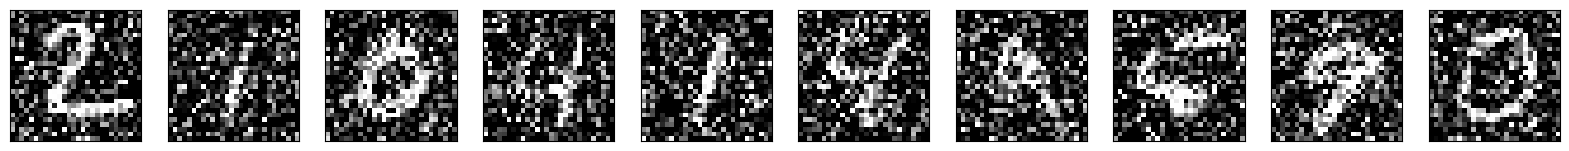

In [10]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 15s 9ms/step - loss: 0.1678 - val_loss: 0.1158
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1119 - val_loss: 0.1073
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1068 - val_loss: 0.1044
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1044 - val_loss: 0.1027
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1026 - val_loss: 0.1010
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1013 - val_loss: 0.1000
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1003 - val_loss: 0.0992
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0995 - val_loss: 0.0983
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0988 - val_loss: 0.0977
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0983 - val_l

In [37]:
n_samples = 10
test_sample = x_test_noisy[0:n_samples,:,:,:]
display(type(test_sample))
display(test_sample.shape)

numpy.ndarray

(10, 28, 28, 1)

In [38]:
predicted = autoencoder.predict(test_sample)
display(type(predicted))
display(predicted.shape)

1/1 [==============================] - 0s 19ms/step


numpy.ndarray

(10, 28, 28, 1)

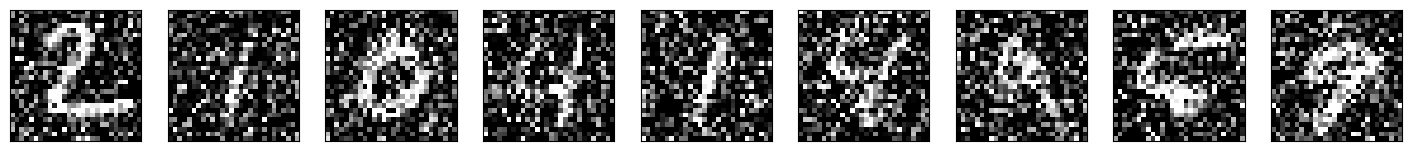

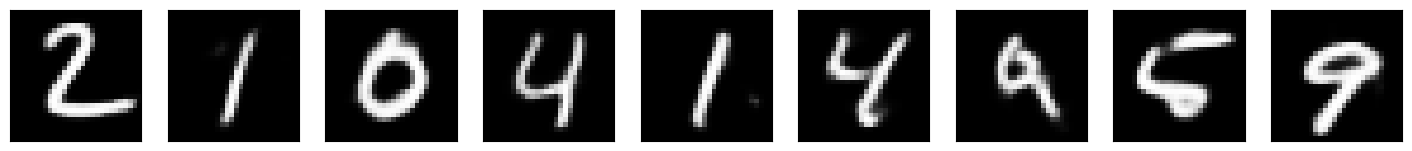

In [39]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n_samples):
    ax = plt.subplot(1, n, i)
    plt.imshow(test_sample[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 2))
for i in range(1, n_samples):
    ax = plt.subplot(1, n, i)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
images = []
for f in glob.iglob("/content/drive/MyDrive/Colab Notebooks/faces/1500/*"):
    images.append(np.asarray(Image.open(f)))

images = np.array(images)


In [5]:
display(type(images))
display(images.shape)

numpy.ndarray

(3004, 256, 256, 3)

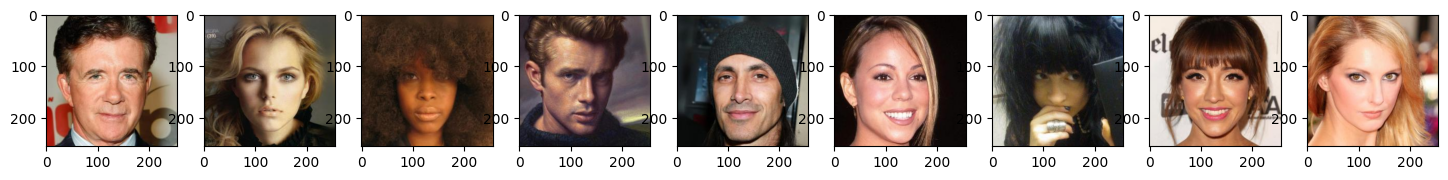

In [6]:
n_samples= 10
plt.figure(figsize=(20, 2))
for i in range(1,10):
  ax = plt.subplot(1, n_samples, i)
  plt.imshow(images[i].reshape(256,256,3))

In [7]:
from sklearn.model_selection import train_test_split

celeb_train, celeb_test = train_test_split(images, test_size=0.2)

In [8]:
display(celeb_train.shape,celeb_test.shape)

(2403, 256, 256, 3)

(601, 256, 256, 3)

In [9]:
import random
import cv2

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [10]:
celeb_train_noisy = np.asarray([ sp_noise(_, 0.1) for _ in celeb_train])
celeb_test_noisy = np.asarray([ sp_noise(_, 0.1) for _ in celeb_test])

In [11]:

celeb_train = celeb_train / 255.0
celeb_test = celeb_test / 255.0
# reduce images
celeb_train_noisy = celeb_train_noisy / 255.0
celeb_test_noisy = celeb_test_noisy / 255.0

In [12]:
display(celeb_train_noisy.shape, celeb_train.shape)
display(celeb_test_noisy.shape, celeb_test.shape)

(2403, 256, 256, 3)

(2403, 256, 256, 3)

(601, 256, 256, 3)

(601, 256, 256, 3)

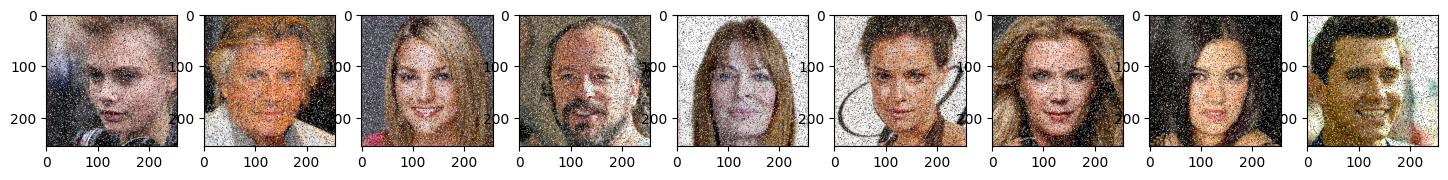

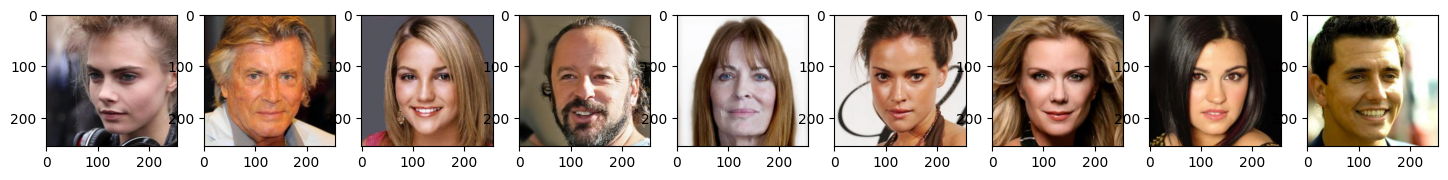

In [13]:
n_samples= 10
plt.figure(figsize=(20, 2))
for i in range(1,10):
  ax = plt.subplot(1, n_samples, i)
  plt.imshow(celeb_train_noisy[i])

plt.figure(figsize=(20, 2))
for i in range(1,10):
  ax = plt.subplot(1, n_samples, i)
  plt.imshow(celeb_train[i])

In [14]:
def create_model():
  x = layers.Input(shape=(256, 256, 3))
# Encoder
  e_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = layers.BatchNormalization()(pool1)
  e_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = layers.BatchNormalization()(pool2)
  e_conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = layers.MaxPooling2D((2, 2), padding='same')(e_conv3)
# Decoder

  d_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(h)

  up1 = layers.UpSampling2D((2, 2))(d_conv1)

  d_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)

  up2 = layers.UpSampling2D((2, 2))(d_conv2)

  d_conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up2)

  up3 = layers.UpSampling2D((2, 2))(d_conv3)

  r = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

  model = keras.Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model
gaussian_auto_encoder = create_model()

In [15]:
gaussian_auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0     

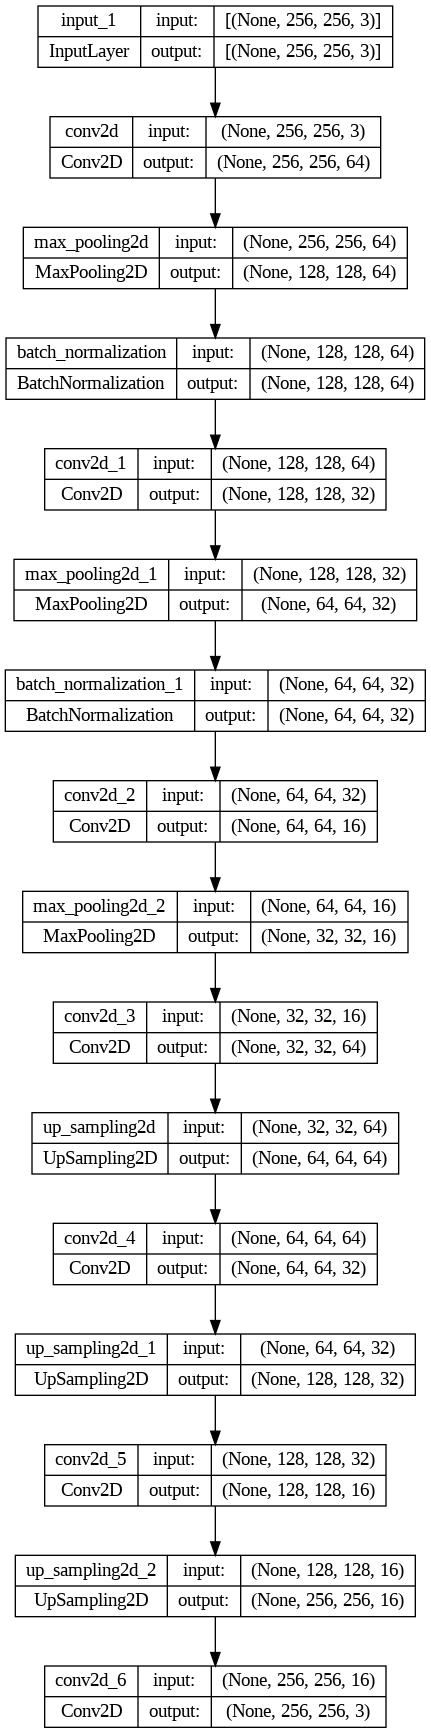

In [16]:
plot_model(gaussian_auto_encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
#gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(celeb_train_noisy, celeb_train, epochs=200, batch_size=32)

Epoch 1/200
76/76 [==============================] - 9s 45ms/step - loss: 0.0146
Epoch 2/200
76/76 [==============================] - 3s 42ms/step - loss: 0.0064
Epoch 3/200
76/76 [==============================] - 3s 42ms/step - loss: 0.0058
Epoch 4/200
76/76 [==============================] - 3s 42ms/step - loss: 0.0049
Epoch 5/200
76/76 [==============================] - 3s 41ms/step - loss: 0.0052
Epoch 6/200
76/76 [==============================] - 3s 42ms/step - loss: 0.0046
Epoch 7/200
76/76 [==============================] - 3s 42ms/step - loss: 0.0043
Epoch 8/200
76/76 [==============================] - 3s 41ms/step - loss: 0.0041
Epoch 9/200
76/76 [==============================] - 3s 42ms/step - loss: 0.0042
Epoch 10/200
76/76 [==============================] - 3s 42ms/step - loss: 0.0044
Epoch 11/200
76/76 [==============================] - 3s 42ms/step - loss: 0.0040
Epoch 12/200
76/76 [==============================] - 3s 41ms/step - loss: 0.0036
Epoch 13/200
76/76 [=====

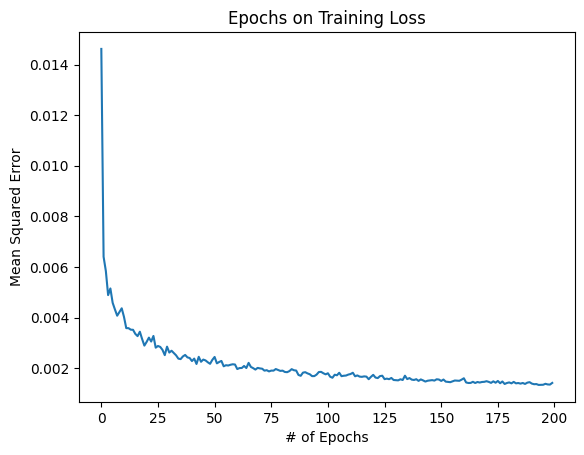

In [18]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [19]:
predicted = gaussian_auto_encoder.predict(celeb_test_noisy)
display(type(predicted))
display(predicted.shape)

19/19 [==============================] - 1s 27ms/step


numpy.ndarray

(601, 256, 256, 3)

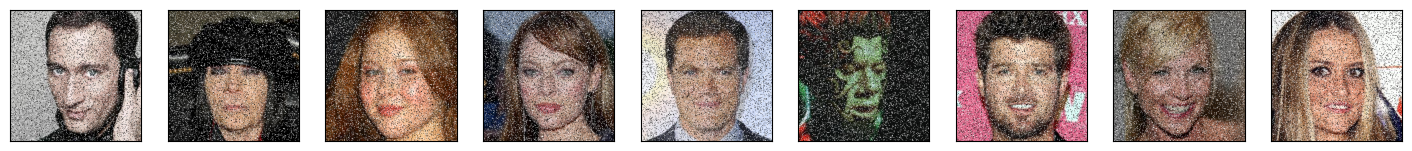

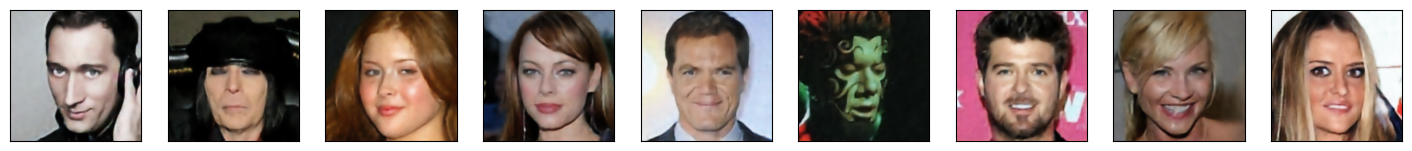

In [20]:
n = 10
plt.figure(figsize=(20, 10))
for i in range(1, n_samples):
    ax = plt.subplot(1, n, i)
    plt.imshow(celeb_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, n_samples):
    ax = plt.subplot(1, n, i)
    plt.imshow(predicted[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
gaussian_auto_encoder.save("/content/drive/MyDrive/Colab Notebooks/250_400")

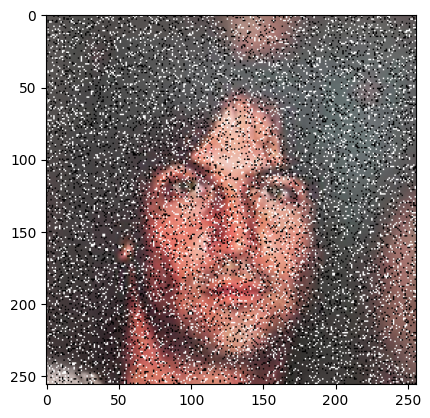

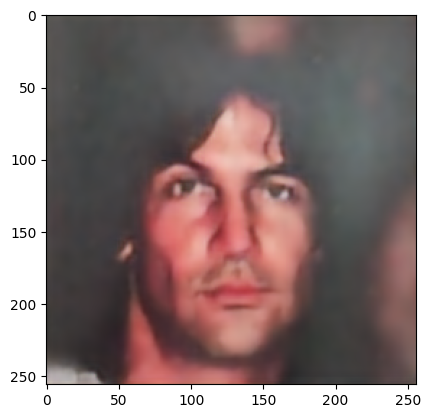

In [22]:
plt.imshow(celeb_test_noisy[-6])
plt.show()
plt.imshow(predicted[-6])
plt.show()

In [23]:
gaussian_auto_encoder.save("/content/drive/MyDrive/Colab Notebooks/model_1500_200_215.keras")


In [24]:
gaussian_auto_encoder.save_weights("/content/drive/MyDrive/Colab Notebooks/model_1500_200_215weights")


In [25]:
import pickle

pickle.dump(gaussian_auto_encoder, open("/content/drive/MyDrive/Colab Notebooks/model_1500_200_215.pkl", 'wb'))

In [26]:
tf. __version__

'2.14.0'

In [27]:
from google.colab import runtime
runtime.unassign()